# Bulldozer dataset

This notebook will use a datasets with a large number of columns (>30) and will propose and entire pipeline of treatments.

After this it will focus on the subjects of datasets distribution/randomness and features selection.

In [1]:
import os
import json
import random
from pathlib import Path
from zipfile import ZipFile

In [2]:
import kaggle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [3]:
kaggle_data = json.load(open(str(Path.home()) + '/kaggle.json', 'r'))
KAGGLE_USERNAME = kaggle_data['username']
KAGGLE_KEY = kaggle_data['key']

In [4]:
if KAGGLE_KEY and KAGGLE_USERNAME: print('Successfully imported access to kaggle')

Successfully imported access to kaggle


In [5]:
os.environ['KAGGLE_USERNAME'] = KAGGLE_USERNAME
os.environ['KAGGLE_KEY'] = KAGGLE_KEY

In [6]:
!rm -rf data/ && rm -rf *.zip

print('Dataset will be downloaded as zip under the current directory')
!kaggle datasets download -d farhanreynaldo/blue-book-for-bulldozer

Dataset will be downloaded as zip under the current directory
 31%|███████████▊                          | 3.00M/9.69M [00:00<00:00, 30.9MB/s]
100%|██████████████████████████████████████| 9.69M/9.69M [00:00<00:00, 60.3MB/s]


In [7]:
!unzip *.zip -d ./data

Archive:  blue-book-for-bulldozer.zip
  inflating: ./data/Test.csv         
  inflating: ./data/Train/Train.csv  
  inflating: ./data/Valid/Valid.csv  


In [8]:
!ls data/

Test.csv  Train  Valid


In [9]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [10]:
df_raw = pd.read_csv('./data/Train/Train.csv')

/home/nelth/anaconda3/envs/ml-playground/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (13,39,40,41) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [11]:
len(df_raw.columns)

53

In [12]:
display_all(df_raw.head().T)

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000,57000,10000,38500,11000
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3.0,3.0,3.0,3.0,3.0
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68.0,4640.0,2838.0,3486.0,722.0
UsageBand,Low,Low,High,High,Medium
saledate,11/16/2006 0:00,3/26/2004 0:00,2/26/2004 0:00,5/19/2011 0:00,7/23/2009 0:00


## Just a little of EDA

First let's define our X and y, then separate on two set to be able to compute training metrics
- Independant variable (X) -> Time, categories of product plus most of others columns of the datasets
- dependant variable (y) -> SalePrice

In [13]:
current_key = 'SalePrice'
current = df_raw[current_key]
current.min(), current.max(), current.mean(), current.median()

(4750, 142000, 31099.71284761608, 24000.0)

array([[<AxesSubplot:title={'center':'SalePrice'}>]], dtype=object)

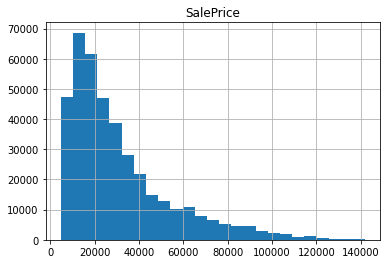

In [14]:
df_raw.hist(column=current_key, bins=25)

The data look like a Logonormal distribution which is quite weird...

## Data cleaning

### Date and log(independant variable)

<class 'numpy.ndarray'>


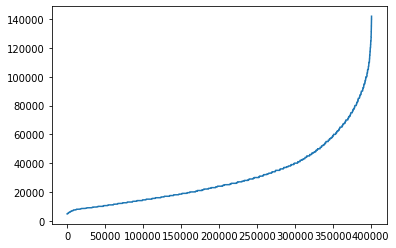

In [15]:
salePrice = df_raw.SalePrice.sort_values(ascending=True).values
print(type(salePrice))

plt.plot(salePrice)

In [16]:
import re

def add_datecols(df, fldname, drop=True):
    fld = df[fldname]
    if not np.issubdtype(fld.dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, 
                                     infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    for n in ('Year', 'Month', 'Week', 'Day', 'Dayofweek', 
            'Dayofyear', 'Is_month_end', 'Is_month_start', 
            'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 
            'Is_year_start'):
        df[targ_pre+n] = getattr(fld.dt,n.lower())
        df[targ_pre+'Elapsed'] = fld.astype(np.int64) // 10**9
    if drop: 
        df = df.drop(fldname, axis=1)
    return df

In [17]:
df = add_datecols(df_raw, 'saledate')

/tmp/ipykernel_7240/155534989.py:14: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  df[targ_pre+'Elapsed'] = fld.astype(np.int64) // 10**9
/tmp/ipykernel_7240/155534989.py:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df[targ_pre+n] = getattr(fld.dt,n.lower())


In [18]:
len(df.columns), df.columns

(65,
 Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
        'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
        'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries',
        'fiModelDescriptor', 'ProductSize', 'fiProductClassDesc', 'state',
        'ProductGroup', 'ProductGroupDesc', 'Drive_System', 'Enclosure',
        'Forks', 'Pad_Type', 'Ride_Control', 'Stick', 'Transmission',
        'Turbocharged', 'Blade_Extension', 'Blade_Width', 'Enclosure_Type',
        'Engine_Horsepower', 'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier',
        'Tip_Control', 'Tire_Size', 'Coupler', 'Coupler_System',
        'Grouser_Tracks', 'Hydraulics_Flow', 'Track_Type',
        'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb', 'Pattern_Changer',
        'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
        'Differential_Type', 'Steering_Controls', 'saleYear', 'saleElapsed',
        'saleMonth', 'saleWeek', 'saleDay', 

In [19]:
df.SalePrice = np.log(df_raw.SalePrice)

<class 'numpy.ndarray'>


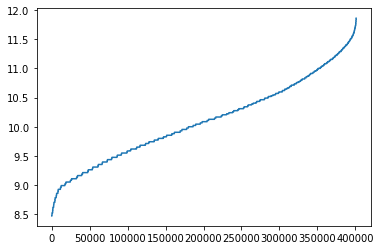

In [20]:
salePrice = df.SalePrice.sort_values(ascending=True).values
print(type(salePrice))

plt.plot(salePrice)

### Set categorical variables

In [21]:
display_all(df.head().T)

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,11.09741,10.950807,9.21034,10.558414,9.305651
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3.0,3.0,3.0,3.0,3.0
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68.0,4640.0,2838.0,3486.0,722.0
UsageBand,Low,Low,High,High,Medium
fiModelDesc,521D,950FII,226,PC120-6E,S175


In [22]:
to_categories = ['fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc', 'Enclosure',
                 'Forks', 'Ride_Control', 'Hydraulics', 'Tire_Size', 'Differential_Type', 
                 'Steering_Controls', 'UsageBand', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'Coupler']

In [23]:
def set_categories(df, cat_to_set):
    for cat in to_categories:
        df[cat] = df[cat].fillna(method='pad') # Filling value with previous one
        df[cat] = df[cat].astype('category')
    return df

In [24]:
df = set_categories(df, to_categories)

#### From categories to encoding

In [25]:
from sklearn.preprocessing import OrdinalEncoder

def set_numerical_cat(df, to_categories):
    ordinal_encoder = OrdinalEncoder()
    for cat in to_categories:
        try:
            df[cat] = ordinal_encoder.fit_transform(
                df[[cat]]
            )
        except Exception:
            print(cat)
    return df

In [26]:
df = set_numerical_cat(df, to_categories)

### Filling null values

In [27]:
with_null_values = df.columns[df.isna().any()].tolist(); len(with_null_values)

30

In [28]:
for with_nulls in with_null_values:
    df[with_nulls] = df[with_nulls].fillna(method='pad') # Filling value with previous one

In [29]:
with_null_values = df.columns[df.isna().any()].tolist(); len(with_null_values)

28

In [30]:
def drop_cols_with_nulls(df, cols_to_drop):
    for col in cols_to_drop:
        df = df.drop(col, axis=1)
    return df

In [31]:
df = drop_cols_with_nulls(df, with_null_values)

In [32]:
with_null_values = df.columns[df.isna().any()].tolist(); len(with_null_values)

0

In [33]:
df.shape

(401125, 37)

## EDA on current dataframe

In [34]:
display_all(df.head().T)

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,11.09741,10.950807,9.21034,10.558414,9.305651
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3.0,3.0,3.0,3.0,3.0
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68.0,4640.0,2838.0,3486.0,722.0
UsageBand,1.0,1.0,0.0,0.0,2.0
fiModelDesc,949.0,1724.0,330.0,3673.0,4207.0


In [35]:
current_key = 'SalePrice'
current = df[current_key]
current.min(), current.max(), current.mean(), current.median()

(8.465899897028686, 11.863582336583399, 10.10309601568253, 10.085809109330082)

array([[<AxesSubplot:title={'center':'SalePrice'}>]], dtype=object)

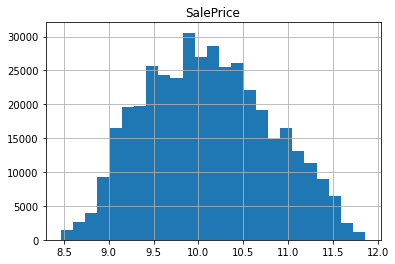

In [36]:
df.hist(column=current_key, bins=25)

The data look now alike a normal distribution

In [37]:
!pip install pyarrow

In [38]:
!mkdir tmp

mkdir: cannot create directory ‘tmp’: File exists


In [39]:
df.to_feather('tmp/feather')

## Base model fitting

On this example we will not use the current log(SalePrice) which is present on the dataframe but the original one.

In [40]:
import sklearn.metrics as metrics

def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [41]:
df.SalePrice = df_raw.SalePrice

In [42]:
X, y = df.drop('SalePrice', axis=1), df.SalePrice.values

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [44]:
X_train.shape, type(X_train), y_train.shape, type(y_train)

((320900, 36), pandas.core.frame.DataFrame, (320900,), numpy.ndarray)

In [45]:
y_train = y_train.reshape(-1, 1)

In [46]:
y_test = y_test.reshape(-1, 1)

In [47]:
m = RandomForestRegressor(n_jobs=-1)

In [48]:
%time m.fit(X_train, y_train)

<timed eval>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


CPU times: user 8min 57s, sys: 3.8 s, total: 9min 1s
Wall time: 1min 15s


RandomForestRegressor(n_jobs=-1)

In [49]:
m.score(X_train, y_train)

0.985275718876005

In [50]:
# ??m.score

In [51]:
preds = m.predict(X_test)

In [52]:
regression_results(y_test, preds)

explained_variance:  0.8953
mean_squared_log_error:  0.0526
r2:  0.8953
MAE:  4638.1802
MSE:  55744832.7587
RMSE:  7466.2462


The error measurement is terrible, let's move to a log(dependant variable)